In [1]:
%autosave 60

import tensorflow as tf
import numpy as np
from tensorflow.contrib.layers import batch_norm, dropout
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

Autosaving every 60 seconds
Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [2]:
def he_normal_initialisation(n_inputs, n_outputs):
    stddev = np.power(2 / (n_inputs + n_outputs), 1 / np.sqrt(2))
    # truncated normal distributions limit the size of the weights, speeding up the training time.
    return tf.truncated_normal((n_inputs, n_outputs), stddev=stddev)

def he_uniform_initialisation(n_inputs, n_outputs):
    r = np.power(6 / (n_inputs + n_outputs), 1 / np.sqrt(2))
    # truncated normal distributions limit the size of the weights, speeding up the training time.
    return tf.random_uniform((n_inputs, n_outputs), -r, r)

def neuron_layer(X, n_neurons, name):
    with tf.name_scope(name):
        #print(X.get_shape()[1])
        n_inputs = int(X.get_shape()[1])
        W = tf.Variable(he_normal_initialisation(n_inputs, n_neurons), name="weights")
        b = tf.Variable(tf.zeros([n_neurons]), name="biases")
        z = tf.matmul(X, W) + b
        return tf.nn.elu(z)

def cnn_layer(X, patch_size, n_input_filters, n_filters, name, initialised_weights_stddev = 0.05):
    with tf.name_scope(name):
        w = tf.Variable(tf.truncated_normal(
            [patch_size, patch_size, n_input_filters, n_filters], stddev=initialised_weights_stddev))
        b = tf.Variable(tf.zeros([n_filters]))
        m = tf.nn.elu(tf.nn.conv2d(X, w, strides=[1, 2, 2, 1], padding="SAME") + b)
        return tf.nn.local_response_normalization(m, depth_radius=7, alpha=1.2)

In [3]:
import math
from sklearn.base import BaseEstimator, ClassifierMixin

class CnnClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_cnn_layers=3, first_cnn_n_neurons=200, ccn_layer_ratio=0.5, fully_connected_neurons = 1200,
                learning_rate=0.01):
        self.n_cnn_layers = n_cnn_layers
        self.first_cnn_n_neurons = first_cnn_n_neurons
        self.ccn_layer_ratio = ccn_layer_ratio
        self.fully_connected_neurons = fully_connected_neurons
        self.learning_rate = learning_rate
        self._build_graph()

    def _build_graph(self):
        input_spatial_size = 28
        input_channels = 1
        n_filters_per_layer = [int(self.first_cnn_n_neurons * (self.ccn_layer_ratio ** i)) for i in range(self.n_cnn_layers)]
        print("n_filters_per_layer:", n_filters_per_layer)
        patch_size = 3
        self.n_output = 10
        self.batch_size = 200
        
        with tf.device("/gpu:0"):
            self.x = tf.placeholder(tf.float32, shape=(None, input_spatial_size ** 2), name="input")
            reshaped_x = tf.reshape(self.x, (-1, input_spatial_size, input_spatial_size, 1))
            self.y = tf.placeholder(tf.int64, shape=(None), name="y")

            with tf.name_scope("dnn"):
                input_tensor = reshaped_x
                n_input_filters = input_channels
                for i in range(len(n_filters_per_layer)):
                    input_tensor = cnn_layer(input_tensor, patch_size, n_input_filters, n_filters_per_layer[i], "hidden" + str(i + 1))
                    n_input_filters = n_filters_per_layer[i]
                #avg_pool_output = tf.nn.avg_pool(input_tensor, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
                # If more than one element of the shape list is -1, the tf.reshape operation below will have an error.
                shape = list(map(lambda a: -1 if a == None else a, input_tensor.get_shape().as_list()))
                #print(shape)
                reshape = tf.reshape(input_tensor, [shape[0], shape[1] * shape[2] * shape[3]])
                fc = tf.nn.dropout(neuron_layer(reshape, self.fully_connected_neurons, "fully_connected_one"), keep_prob=0.4)
                #print(reshape.get_shape())
                logits = neuron_layer(fc, self.n_output, "output")
                self.evaluation = tf.nn.softmax(logits)

            with tf.name_scope("loss"):
                cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=self.y, logits=logits)
                self.loss = tf.reduce_mean(cross_entropy, name="loss")

            with tf.name_scope("training"):
                optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
                self.training_op = optimizer.minimize(self.loss)

        with tf.name_scope("eval"):
            k = 1
            correctness = tf.nn.in_top_k(logits, self.y, k)
            self.accuracy = tf.reduce_mean(tf.cast(correctness, tf.float32)) * 100
            
        self.init = tf.global_variables_initializer()

    def fit(self, X, y, epochs = 20):
        saver = tf.train.Saver()

        interim_checkpoint_path = "./checkpoints/mnist_cnn_model.ckpt"
        early_stopping_checkpoint_path = "./checkpoints/mnist_cnn_model_early_stopping.ckpt"

        from datetime import datetime

        now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
        root_logdir = "tf_logs"
        log_dir = "{}/run-{}/".format(root_logdir, now)

        loss_summary = tf.summary.scalar('loss', self.loss)
        accuracy_summary = tf.summary.scalar("accuracy", self.accuracy)
        summary_op = tf.summary.merge([loss_summary, accuracy_summary])
        file_writer = tf.summary.FileWriter(log_dir, tf.get_default_graph())
        
        n_batches = int(np.ceil(len(X) // self.batch_size))

        early_stopping_check_frequency = self.batch_size // 4
        early_stopping_check_limit = self.batch_size * 2

        sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
        self.session = sess
        sess.run(self.init)
        #saver.restore(sess, interim_checkpoint_path)

        best_validation_acc = 0.0
        best_validation_step = 0
        for epoch in range(epochs):
            print("epoch", epoch)
            for batch_index in range(n_batches):
                step = epoch * n_batches + batch_index
                # TODO: replace this with code that gets a batch from X and y.
                X_batch, y_batch = mnist.train.next_batch(self.batch_size)
                if batch_index % 10 == 0:
                    summary_str = summary_op.eval(session=sess, feed_dict={self.x: X_batch, self.y: y_batch})
                    file_writer.add_summary(summary_str, step)
                t, l, a = sess.run([self.training_op, self.loss, self.accuracy], feed_dict={self.x: X_batch, self.y: y_batch})
                if batch_index % 10 == 0: print("loss:", l, "train accuracy:", a)
                # Early stopping check
                if batch_index % early_stopping_check_frequency == 0:
                    validation_acc = self.prediction_accuracy(mnist.validation.images, mnist.validation.labels)
                    print("validation accuracy", validation_acc)
                    if validation_acc > best_validation_acc:
                        saver.save(sess, early_stopping_checkpoint_path)
                        best_validation_acc = validation_acc
                        best_validation_step = step
                    elif step >= (best_validation_step + early_stopping_check_limit):
                        print("Stopping early during epoch", epoch)
                        break
            else:
                continue
            break
            save_path = saver.save(sess, interim_checkpoint_path)
        saver.restore(sess, early_stopping_checkpoint_path)
        save_path = saver.save(sess, "./checkpoints/mnist_cnn_model_final.ckpt")
            
    def predict_proba(self, X):
        dataset_size = X.shape[0]
        #print "dataset_size: ", dataset_size, " batch_size: ", batch_size
        predictions = np.ndarray(shape=(dataset_size, self.n_output), dtype=np.float32)
        steps = int(math.ceil(dataset_size / self.batch_size))
        #print "steps: ", steps
        for step in range(steps):
            offset = (step * self.batch_size)
            #print "offset ", offset
            data_end_index = min(offset + self.batch_size, dataset_size)
            batch_data = X[offset:data_end_index, :]
            feed_dict = {
                self.x: batch_data
            }
            predictions[offset:data_end_index, :] = self.evaluation.eval(session=self.session, feed_dict=feed_dict)
        return predictions

    def predict(self, X):
        return np.argmax(self.predict_proba(X).astype(int), axis=1)
    
    def _prediction_accuracy(self, predictions, labels):
        return (100.0 * np.sum(np.argmax(predictions, 1) == labels)
              / predictions.shape[0])
    
    def prediction_accuracy(self, X, y):
        predictions = self.predict_proba(X)
        return self._prediction_accuracy(predictions, y)

In [ ]:
cnn_clf = CnnClassifier()
cnn_clf.fit(mnist.train.images, mnist.train.labels)

test_acc = cnn_clf.prediction_accuracy(mnist.test.images, mnist.test.labels)
print(">>>>>>>>>> test dataset accuracy:", test_acc)

n_filters_per_layer: [200, 100, 50]
epoch 0
loss: 2.30209 train accuracy: 12.5
validation accuracy 24.22
loss: 1.54832 train accuracy: 58.0
loss: 0.692344 train accuracy: 80.5
loss: 0.391995 train accuracy: 86.5
loss: 0.586151 train accuracy: 86.5
loss: 0.425669 train accuracy: 89.0
validation accuracy 90.0
loss: 0.447733 train accuracy: 92.0
loss: 0.705635 train accuracy: 84.0
loss: 0.527127 train accuracy: 89.0
loss: 0.317087 train accuracy: 93.0
loss: 0.416529 train accuracy: 90.0
validation accuracy 92.1
loss: 0.396785 train accuracy: 93.0
loss: 0.234168 train accuracy: 93.0
loss: 0.555101 train accuracy: 86.5
loss: 0.31508 train accuracy: 93.0
loss: 0.391123 train accuracy: 93.5
validation accuracy 89.18
loss: 0.262894 train accuracy: 94.5
loss: 0.495407 train accuracy: 91.0
loss: 0.453261 train accuracy: 92.0
loss: 0.480198 train accuracy: 92.0
loss: 0.286685 train accuracy: 95.0
validation accuracy 93.52
loss: 0.517044 train accuracy: 91.0
loss: 0.34169 train accuracy: 94.0
loss

In [5]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_cnn_layers": range(1, 15),
    "first_cnn_n_neurons": [100, 200, 400, 800, 1000, 1200, 2000],
    "ccn_layer_ratio": [0.3, 0.5, 0.7, 0.9],
    "fully_connected_neurons": [200, 500, 1000, 1200, 1500, 2000, 3000],
    "learning_rate": [0.001, 0.005, 0.01, 0.02, 0.05],
    #"batch_size": [10, 50, 100, 500],
    #"activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
}

rnd_search = RandomizedSearchCV(CnnClassifier(), param_distribs, n_iter=10,
                                #fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000},
                                random_state=42, verbose=2)
rnd_search.fit(mnist.train.images, mnist.train.labels)

n_filters_per_layer: [200, 100, 50]
Fitting 3 folds for each of 10 candidates, totalling 30 fits
n_filters_per_layer: [200, 100, 50]
n_filters_per_layer: [200, 100, 50]
[CV] n_cnn_layers=5, learning_rate=0.05, first_cnn_n_neurons=100, ccn_layer_ratio=0.7, fully_connected_neurons=2000 
epoch 0
loss: 2.30245 train accuracy: 11.0
validation accuracy 15.52
loss: 1.11546 train accuracy: 74.0
loss: 0.730268 train accuracy: 79.0
loss: 0.411462 train accuracy: 89.0
loss: 0.750479 train accuracy: 83.0
loss: 0.507159 train accuracy: 87.0
validation accuracy 88.24
loss: 0.464346 train accuracy: 89.0
loss: 0.385577 train accuracy: 91.5
loss: 0.442568 train accuracy: 86.0
loss: 0.248342 train accuracy: 92.5
loss: 0.3675 train accuracy: 92.0
validation accuracy 91.0
loss: 0.362421 train accuracy: 88.5
loss: 0.248657 train accuracy: 92.5
loss: 0.722385 train accuracy: 85.5
loss: 0.410028 train accuracy: 90.0
loss: 0.416133 train accuracy: 92.5
validation accuracy 93.2
loss: 0.3788 train accuracy: 94.

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min remaining:    0.0s


epoch 0
loss: 2.30296 train accuracy: 13.0
validation accuracy 27.7
loss: 2.51438 train accuracy: 31.5
loss: 2.06654 train accuracy: 28.5
loss: 1.90181 train accuracy: 36.5
loss: 1.6956 train accuracy: 45.0
loss: 1.61031 train accuracy: 53.0
validation accuracy 58.3
loss: 1.48256 train accuracy: 56.0
loss: 1.23328 train accuracy: 67.5
loss: 1.60846 train accuracy: 54.5
loss: 1.137 train accuracy: 64.0
loss: 0.995648 train accuracy: 70.0
validation accuracy 66.0
loss: 1.18989 train accuracy: 62.5
loss: 1.13734 train accuracy: 61.0
loss: 1.02756 train accuracy: 72.0
loss: 0.986256 train accuracy: 75.0
loss: 1.08064 train accuracy: 68.5
validation accuracy 75.76
loss: 0.974545 train accuracy: 76.0
loss: 0.782167 train accuracy: 79.5
loss: 0.885435 train accuracy: 74.5
epoch 1
loss: 0.887207 train accuracy: 72.0
validation accuracy 74.3
loss: 0.624034 train accuracy: 79.0
loss: 0.67962 train accuracy: 79.5
loss: 0.829248 train accuracy: 74.5
loss: 0.703396 train accuracy: 80.5
loss: 0.7375

loss: 0.457471 train accuracy: 92.5
validation accuracy 93.62
loss: 0.590839 train accuracy: 93.0
loss: 0.347082 train accuracy: 94.5
loss: 0.414186 train accuracy: 92.5
loss: 0.393118 train accuracy: 95.5
loss: 0.45369 train accuracy: 93.0
validation accuracy 93.14
loss: 0.262467 train accuracy: 96.5
loss: 0.359774 train accuracy: 93.5
loss: 0.660749 train accuracy: 91.0
epoch 2
loss: 0.490891 train accuracy: 93.5
validation accuracy 95.16
loss: 0.448454 train accuracy: 93.0
loss: 0.453605 train accuracy: 96.0
loss: 0.771971 train accuracy: 92.0
loss: 0.360158 train accuracy: 94.5
loss: 0.558863 train accuracy: 92.5
validation accuracy 94.12
loss: 0.284205 train accuracy: 96.0
loss: 0.423538 train accuracy: 92.0
loss: 0.548322 train accuracy: 92.5
loss: 0.566278 train accuracy: 91.0
loss: 0.486213 train accuracy: 92.5
validation accuracy 95.06
loss: 0.195953 train accuracy: 98.0
loss: 0.44417 train accuracy: 95.5
loss: 0.614335 train accuracy: 93.5
loss: 0.183437 train accuracy: 97.0


loss: 0.504603 train accuracy: 93.0
validation accuracy 95.14
loss: 0.376408 train accuracy: 96.5
loss: 0.35812 train accuracy: 93.5
loss: 0.743287 train accuracy: 96.5
loss: 0.495107 train accuracy: 95.5
loss: 0.356652 train accuracy: 96.5
validation accuracy 95.54
loss: 0.367317 train accuracy: 96.5
loss: 0.481727 train accuracy: 94.5
loss: 0.322447 train accuracy: 99.0
loss: 0.222108 train accuracy: 97.0
loss: 0.364693 train accuracy: 96.5
validation accuracy 95.64
loss: 0.386909 train accuracy: 98.0
loss: 0.434774 train accuracy: 95.0
loss: 0.225848 train accuracy: 98.5
loss: 0.381828 train accuracy: 96.5
loss: 0.300654 train accuracy: 96.5
validation accuracy 93.8
loss: 0.546575 train accuracy: 97.5
loss: 0.338215 train accuracy: 98.5
loss: 0.371812 train accuracy: 98.0
epoch 6
loss: 0.204939 train accuracy: 98.0
validation accuracy 96.2
loss: 0.437123 train accuracy: 96.5
loss: 0.271592 train accuracy: 97.5
loss: 0.333574 train accuracy: 96.5
loss: 0.476273 train accuracy: 96.0
l

loss: 0.385718 train accuracy: 89.5
loss: 0.486423 train accuracy: 90.5
loss: 0.370371 train accuracy: 91.5
loss: 0.291009 train accuracy: 93.0
validation accuracy 94.08
loss: 0.293704 train accuracy: 95.5
loss: 0.27564 train accuracy: 92.5
loss: 0.457845 train accuracy: 87.5
epoch 1
loss: 0.311081 train accuracy: 92.5
validation accuracy 93.18
loss: 0.527156 train accuracy: 87.5
loss: 0.367703 train accuracy: 92.5
loss: 0.217288 train accuracy: 92.5
loss: 0.275516 train accuracy: 94.0
loss: 0.207061 train accuracy: 95.5
validation accuracy 92.26
loss: 0.698142 train accuracy: 87.0
loss: 0.220229 train accuracy: 94.5
loss: 0.206669 train accuracy: 95.0
loss: 0.50002 train accuracy: 92.5
loss: 0.565037 train accuracy: 87.5
validation accuracy 94.28
loss: 0.30992 train accuracy: 94.0
loss: 0.290357 train accuracy: 94.0
loss: 0.266366 train accuracy: 95.5
loss: 0.116733 train accuracy: 97.5
loss: 0.667098 train accuracy: 91.5
validation accuracy 95.3
loss: 0.454054 train accuracy: 90.0
lo

loss: 0.2472 train accuracy: 95.5
loss: 0.193507 train accuracy: 97.0
loss: 0.615845 train accuracy: 94.0
loss: 0.307109 train accuracy: 94.5
validation accuracy 95.62
loss: 0.327337 train accuracy: 96.0
loss: 0.188556 train accuracy: 97.0
loss: 0.699092 train accuracy: 92.5
loss: 0.63819 train accuracy: 92.5
loss: 0.466384 train accuracy: 94.5
validation accuracy 94.78
loss: 0.24534 train accuracy: 98.0
loss: 0.487703 train accuracy: 93.5
loss: 0.347259 train accuracy: 96.5
loss: 0.275071 train accuracy: 95.5
loss: 0.286292 train accuracy: 97.0
validation accuracy 95.1
loss: 0.409517 train accuracy: 94.0
loss: 0.39605 train accuracy: 95.0
loss: 0.615515 train accuracy: 93.0
epoch 4
loss: 0.325516 train accuracy: 96.5
validation accuracy 95.54
loss: 0.379015 train accuracy: 96.5
loss: 0.273548 train accuracy: 97.5
loss: 0.391815 train accuracy: 95.5
loss: 0.457487 train accuracy: 96.5
loss: 0.472136 train accuracy: 94.5
validation accuracy 94.82
loss: 0.271938 train accuracy: 97.0
loss

loss: 0.801522 train accuracy: 92.0
loss: 0.1969 train accuracy: 95.5
loss: 0.873047 train accuracy: 92.0
loss: 0.228391 train accuracy: 97.0
loss: 0.371582 train accuracy: 95.5
validation accuracy 94.84
loss: 0.56877 train accuracy: 95.5
loss: 0.237302 train accuracy: 96.5
loss: 0.361379 train accuracy: 96.0
epoch 4
loss: 0.258446 train accuracy: 98.5
validation accuracy 94.96
loss: 0.437188 train accuracy: 95.5
loss: 0.115485 train accuracy: 98.5
loss: 0.304748 train accuracy: 95.5
loss: 0.471902 train accuracy: 95.0
loss: 0.168401 train accuracy: 98.0
validation accuracy 94.7
loss: 0.219398 train accuracy: 95.5
loss: 0.515966 train accuracy: 95.0
loss: 0.30578 train accuracy: 99.0
loss: 0.429581 train accuracy: 96.0
loss: 0.333591 train accuracy: 96.5
validation accuracy 95.38
loss: 0.51485 train accuracy: 94.0
loss: 0.295385 train accuracy: 98.0
loss: 0.340258 train accuracy: 98.0
loss: 0.693275 train accuracy: 96.5
loss: 0.33043 train accuracy: 98.0
validation accuracy 92.32
loss:

[CV] n_cnn_layers=7, learning_rate=0.02, first_cnn_n_neurons=2000, ccn_layer_ratio=0.9, fully_connected_neurons=1000 
epoch 0
loss: 2.3013 train accuracy: 16.0
validation accuracy 25.78
loss: 1.71519 train accuracy: 60.0
loss: 0.713803 train accuracy: 82.0
loss: 1.09986 train accuracy: 81.0
loss: 0.487284 train accuracy: 87.0
loss: 0.525058 train accuracy: 85.0
validation accuracy 85.28
loss: 0.411604 train accuracy: 89.5
loss: 0.22285 train accuracy: 92.5
loss: 0.239427 train accuracy: 94.0
loss: 0.400479 train accuracy: 91.5
loss: 0.359037 train accuracy: 92.5
validation accuracy 92.1
loss: 0.184614 train accuracy: 96.0
loss: 0.53606 train accuracy: 88.5
loss: 0.393022 train accuracy: 90.5
loss: 0.428517 train accuracy: 90.0
loss: 0.449801 train accuracy: 89.0
validation accuracy 89.64
loss: 0.415922 train accuracy: 90.5
loss: 0.543774 train accuracy: 87.5
loss: 0.575458 train accuracy: 87.5
epoch 1
loss: 0.73898 train accuracy: 90.0
validation accuracy 93.72
loss: 0.187709 train acc

loss: 0.325772 train accuracy: 91.5
loss: 0.34357 train accuracy: 94.5
loss: 0.237846 train accuracy: 95.5
loss: 0.358677 train accuracy: 93.5
loss: 0.121965 train accuracy: 96.5
validation accuracy 95.46
loss: 0.438742 train accuracy: 94.0
loss: 0.426945 train accuracy: 95.5
loss: 0.442668 train accuracy: 94.0
loss: 0.451255 train accuracy: 94.5
loss: 0.880762 train accuracy: 88.0
validation accuracy 94.06
loss: 0.261454 train accuracy: 96.5
loss: 0.309559 train accuracy: 94.0
loss: 0.411856 train accuracy: 94.5
epoch 3
loss: 0.558216 train accuracy: 95.0
validation accuracy 95.98
loss: 0.30736 train accuracy: 95.0
loss: 0.344894 train accuracy: 95.5
loss: 0.218352 train accuracy: 95.0
loss: 0.394362 train accuracy: 95.5
loss: 0.237783 train accuracy: 96.0
validation accuracy 93.48
loss: 0.518552 train accuracy: 94.0
loss: 0.512332 train accuracy: 95.5
loss: 0.325082 train accuracy: 97.0
loss: 0.395182 train accuracy: 95.0
loss: 0.437523 train accuracy: 95.0
validation accuracy 95.52


validation accuracy 95.54
loss: 0.336861 train accuracy: 96.5
loss: 0.458382 train accuracy: 95.5
loss: 0.36267 train accuracy: 95.5
loss: 0.172136 train accuracy: 96.5
loss: 0.232622 train accuracy: 98.5
validation accuracy 94.7
loss: 0.154745 train accuracy: 96.5
loss: 0.109133 train accuracy: 97.0
loss: 0.200109 train accuracy: 96.5
epoch 5
loss: 0.584813 train accuracy: 96.5
validation accuracy 96.46
loss: 0.344319 train accuracy: 96.0
loss: 0.12708 train accuracy: 98.0
loss: 0.101932 train accuracy: 98.5
loss: 0.12816 train accuracy: 98.5
loss: 0.300214 train accuracy: 98.0
validation accuracy 96.1
loss: 0.365822 train accuracy: 95.5
loss: 0.374333 train accuracy: 95.0
loss: 0.485018 train accuracy: 97.5
loss: 0.437027 train accuracy: 95.5
loss: 0.443132 train accuracy: 96.5
validation accuracy 96.12
loss: 0.510566 train accuracy: 97.0
loss: 0.324148 train accuracy: 96.5
loss: 0.39983 train accuracy: 95.0
loss: 0.530136 train accuracy: 96.0
loss: 0.153183 train accuracy: 97.5
vali

loss: 0.238382 train accuracy: 99.5
loss: 0.319519 train accuracy: 96.0
loss: 0.342972 train accuracy: 94.0
loss: 0.1276 train accuracy: 99.0
loss: 0.306116 train accuracy: 98.5
validation accuracy 96.22
loss: 0.314147 train accuracy: 97.0
loss: 0.40264 train accuracy: 95.5
loss: 0.284006 train accuracy: 98.0
loss: 0.386382 train accuracy: 96.0
loss: 0.16641 train accuracy: 97.5
validation accuracy 95.32
loss: 0.556751 train accuracy: 98.0
loss: 0.370648 train accuracy: 98.0
loss: 0.226663 train accuracy: 97.0
loss: 0.232952 train accuracy: 96.5
loss: 0.268363 train accuracy: 97.0
validation accuracy 94.16
loss: 0.470139 train accuracy: 96.5
loss: 0.288025 train accuracy: 97.0
loss: 0.513144 train accuracy: 97.0
epoch 8
loss: 0.136717 train accuracy: 98.5
validation accuracy 94.56
loss: 0.40022 train accuracy: 97.0
loss: 0.12955 train accuracy: 99.0
loss: 0.234697 train accuracy: 97.0
loss: 0.326881 train accuracy: 98.0
loss: 1.00144 train accuracy: 95.0
validation accuracy 94.38
Stopp

loss: 0.644586 train accuracy: 92.5
loss: 0.226489 train accuracy: 94.5
validation accuracy 95.14
loss: 0.352083 train accuracy: 93.5
loss: 0.313812 train accuracy: 94.0
loss: 0.63891 train accuracy: 92.5
epoch 3
loss: 0.422972 train accuracy: 94.5
validation accuracy 95.4
loss: 0.34767 train accuracy: 94.5
loss: 0.270825 train accuracy: 94.0
loss: 0.452081 train accuracy: 92.0
loss: 0.329054 train accuracy: 95.5
loss: 0.295759 train accuracy: 95.5
validation accuracy 96.08
loss: 0.243189 train accuracy: 95.5
loss: 0.475223 train accuracy: 94.0
loss: 0.186805 train accuracy: 97.5
loss: 0.28424 train accuracy: 97.5
loss: 0.458986 train accuracy: 94.0
validation accuracy 96.06
loss: 0.258491 train accuracy: 95.0
loss: 0.314385 train accuracy: 96.0
loss: 0.439197 train accuracy: 95.0
loss: 0.540209 train accuracy: 93.0
loss: 0.27058 train accuracy: 96.5
validation accuracy 95.36
loss: 0.286844 train accuracy: 97.0
loss: 0.363339 train accuracy: 95.0
loss: 0.263223 train accuracy: 96.0
epo

loss: 0.417928 train accuracy: 95.0
loss: 0.272394 train accuracy: 95.5
validation accuracy 95.86
loss: 0.411593 train accuracy: 94.5
loss: 0.392489 train accuracy: 95.5
loss: 0.282233 train accuracy: 97.0
loss: 0.504674 train accuracy: 95.0
loss: 0.407298 train accuracy: 93.5
validation accuracy 95.5
loss: 0.250085 train accuracy: 98.0
loss: 0.294507 train accuracy: 95.5
loss: 0.190669 train accuracy: 97.0
loss: 0.259463 train accuracy: 97.0
loss: 0.595551 train accuracy: 97.0
validation accuracy 95.84
loss: 0.287382 train accuracy: 96.0
loss: 0.23732 train accuracy: 97.0
loss: 0.445561 train accuracy: 93.0
epoch 5
loss: 0.187665 train accuracy: 98.5
validation accuracy 96.12
loss: 0.242288 train accuracy: 96.5
loss: 0.39173 train accuracy: 96.0
loss: 0.459863 train accuracy: 95.0
loss: 0.759634 train accuracy: 91.0
loss: 0.198995 train accuracy: 97.5
validation accuracy 96.5
loss: 0.362071 train accuracy: 96.5
loss: 0.271712 train accuracy: 95.5
loss: 0.215763 train accuracy: 98.0
lo

loss: 0.0815242 train accuracy: 97.5
loss: 0.337561 train accuracy: 94.5
loss: 0.226716 train accuracy: 95.0
loss: 0.222434 train accuracy: 93.5
loss: 0.253074 train accuracy: 95.5
validation accuracy 94.1
loss: 0.249122 train accuracy: 95.5
loss: 0.209404 train accuracy: 96.0
loss: 0.383236 train accuracy: 96.0
epoch 2
loss: 0.231605 train accuracy: 96.0
validation accuracy 95.26
loss: 0.164878 train accuracy: 97.0
loss: 0.211201 train accuracy: 95.5
loss: 0.321776 train accuracy: 95.0
loss: 0.309454 train accuracy: 96.0
loss: 0.351755 train accuracy: 94.5
validation accuracy 94.04
loss: 0.31305 train accuracy: 95.5
loss: 0.287718 train accuracy: 97.5
loss: 0.337243 train accuracy: 94.0
loss: 0.104356 train accuracy: 98.0
loss: 0.253501 train accuracy: 94.0
validation accuracy 95.58
loss: 0.36836 train accuracy: 95.5
loss: 0.346193 train accuracy: 95.0
loss: 0.275583 train accuracy: 94.0
loss: 0.402481 train accuracy: 94.5
loss: 0.193677 train accuracy: 95.5
validation accuracy 96.32


validation accuracy 95.76
loss: 0.40839 train accuracy: 93.0
loss: 0.227462 train accuracy: 95.5
loss: 0.24754 train accuracy: 96.5
epoch 3
loss: 0.186941 train accuracy: 95.0
validation accuracy 96.22
loss: 0.659097 train accuracy: 91.5
loss: 0.287376 train accuracy: 95.0
loss: 0.444158 train accuracy: 95.5
loss: 0.279422 train accuracy: 96.0
loss: 0.526512 train accuracy: 92.5
validation accuracy 95.44
loss: 0.235198 train accuracy: 97.0
loss: 0.21538 train accuracy: 97.0
loss: 0.319921 train accuracy: 97.0
loss: 0.256633 train accuracy: 98.0
loss: 0.857197 train accuracy: 92.0
validation accuracy 95.82
loss: 0.346785 train accuracy: 94.5
loss: 0.674288 train accuracy: 94.0
loss: 0.581174 train accuracy: 94.5
loss: 0.290245 train accuracy: 95.5
loss: 0.464422 train accuracy: 95.0
validation accuracy 95.0
loss: 0.21809 train accuracy: 97.5
loss: 0.317137 train accuracy: 95.0
loss: 0.198762 train accuracy: 97.0
epoch 4
loss: 0.28155 train accuracy: 95.5
validation accuracy 95.56
loss: 

validation accuracy 96.16
loss: 0.492666 train accuracy: 95.5
loss: 0.219974 train accuracy: 97.0
loss: 0.622221 train accuracy: 95.5
loss: 0.387286 train accuracy: 96.0
loss: 0.446994 train accuracy: 96.5
validation accuracy 93.6
loss: 0.300988 train accuracy: 95.5
loss: 0.361194 train accuracy: 96.0
loss: 0.466811 train accuracy: 96.5
loss: 0.451723 train accuracy: 95.5
loss: 0.726958 train accuracy: 96.5
validation accuracy 95.84
loss: 0.484283 train accuracy: 95.0
loss: 0.345956 train accuracy: 98.5
loss: 0.384671 train accuracy: 95.0
epoch 6
loss: 0.339214 train accuracy: 96.5
validation accuracy 96.3
loss: 0.389403 train accuracy: 96.5
loss: 0.439517 train accuracy: 95.0
loss: 0.171687 train accuracy: 97.0
loss: 0.346099 train accuracy: 95.0
loss: 0.349696 train accuracy: 97.5
validation accuracy 94.64
loss: 0.439037 train accuracy: 97.0
loss: 0.184313 train accuracy: 98.0
loss: 0.151227 train accuracy: 98.0
loss: 0.425662 train accuracy: 96.5
loss: 0.20791 train accuracy: 97.5
v

n_filters_per_layer: [200, 100, 50]
[CV] n_cnn_layers=9, learning_rate=0.05, first_cnn_n_neurons=1000, ccn_layer_ratio=0.5, fully_connected_neurons=1500 
epoch 0
loss: 2.3032 train accuracy: 9.5
validation accuracy 43.02
loss: 1.05815 train accuracy: 72.0
loss: 0.567884 train accuracy: 83.0
loss: 0.651674 train accuracy: 81.0
loss: 0.374685 train accuracy: 90.0
loss: 0.401 train accuracy: 88.0
validation accuracy 90.06
loss: 0.270795 train accuracy: 92.5
loss: 0.366252 train accuracy: 92.5
loss: 0.302565 train accuracy: 89.5
loss: 0.380074 train accuracy: 90.0
loss: 0.310407 train accuracy: 90.0
validation accuracy 93.02
loss: 0.479053 train accuracy: 89.5
loss: 0.367363 train accuracy: 91.0
loss: 0.428405 train accuracy: 91.0
loss: 0.418096 train accuracy: 92.0
loss: 0.361355 train accuracy: 92.5
validation accuracy 90.14
loss: 0.399132 train accuracy: 91.5
loss: 0.433512 train accuracy: 93.0
loss: 0.277619 train accuracy: 95.0
epoch 1
loss: 0.3507 train accuracy: 91.5
validation accu

validation accuracy 95.8
loss: 0.251379 train accuracy: 94.5
loss: 0.328913 train accuracy: 94.5
loss: 0.499588 train accuracy: 94.5
loss: 0.313388 train accuracy: 96.0
loss: 0.401348 train accuracy: 94.0
validation accuracy 95.62
loss: 0.199804 train accuracy: 95.5
loss: 0.423323 train accuracy: 92.0
loss: 0.435762 train accuracy: 95.0
loss: 0.470927 train accuracy: 93.0
loss: 0.485594 train accuracy: 92.0
validation accuracy 94.54
loss: 0.484127 train accuracy: 94.5
loss: 0.325595 train accuracy: 91.5
loss: 0.273164 train accuracy: 95.5
epoch 3
loss: 0.618595 train accuracy: 93.0
validation accuracy 95.56
loss: 0.653103 train accuracy: 92.5
loss: 0.488977 train accuracy: 96.0
loss: 0.617187 train accuracy: 95.0
loss: 0.285469 train accuracy: 95.5
loss: 0.284424 train accuracy: 96.5
validation accuracy 96.42
loss: 0.312922 train accuracy: 94.5
loss: 0.346483 train accuracy: 93.5
loss: 0.174182 train accuracy: 97.0
loss: 0.235045 train accuracy: 96.0
loss: 0.283064 train accuracy: 95.0

loss: 0.309228 train accuracy: 93.5
validation accuracy 95.18
loss: 0.576855 train accuracy: 93.5
loss: 0.205846 train accuracy: 95.5
loss: 0.35722 train accuracy: 93.5
loss: 0.477487 train accuracy: 95.5
loss: 0.451289 train accuracy: 94.0
validation accuracy 94.5
loss: 0.413451 train accuracy: 92.5
loss: 0.565201 train accuracy: 91.5
loss: 0.299109 train accuracy: 95.0
epoch 3
loss: 0.452896 train accuracy: 92.5
validation accuracy 95.54
loss: 0.591914 train accuracy: 90.5
loss: 0.559799 train accuracy: 91.5
loss: 0.203245 train accuracy: 96.0
loss: 0.238906 train accuracy: 96.0
loss: 0.323818 train accuracy: 95.0
validation accuracy 95.76
loss: 0.256892 train accuracy: 95.0
loss: 0.301021 train accuracy: 94.0
loss: 0.396815 train accuracy: 96.0
loss: 0.372244 train accuracy: 95.5
loss: 0.377648 train accuracy: 93.0
validation accuracy 94.92
loss: 0.294529 train accuracy: 96.0
loss: 0.178466 train accuracy: 95.5
loss: 0.351916 train accuracy: 92.0
loss: 0.234117 train accuracy: 96.0


loss: 0.375715 train accuracy: 96.0
validation accuracy 96.7
loss: 0.260991 train accuracy: 96.0
loss: 0.16213 train accuracy: 97.5
loss: 0.293703 train accuracy: 96.5
loss: 0.474061 train accuracy: 96.0
loss: 0.196518 train accuracy: 98.0
validation accuracy 95.98
loss: 0.145531 train accuracy: 98.5
loss: 0.411661 train accuracy: 96.0
loss: 0.454044 train accuracy: 95.5
loss: 0.281251 train accuracy: 98.0
loss: 0.168186 train accuracy: 97.5
validation accuracy 96.58
loss: 0.204294 train accuracy: 97.5
loss: 0.243092 train accuracy: 98.0
loss: 0.257252 train accuracy: 97.0
loss: 0.244542 train accuracy: 96.5
loss: 0.68328 train accuracy: 95.0
validation accuracy 94.32
loss: 0.614809 train accuracy: 94.5
loss: 0.248658 train accuracy: 97.5
loss: 0.250147 train accuracy: 98.0
epoch 6
loss: 0.172774 train accuracy: 99.0
validation accuracy 95.18
loss: 0.999838 train accuracy: 94.5
loss: 0.292638 train accuracy: 96.5
loss: 0.262682 train accuracy: 97.5
loss: 0.244782 train accuracy: 96.5
l

loss: 0.217298 train accuracy: 99.0
loss: 0.160747 train accuracy: 98.0
validation accuracy 95.64
Stopping early during epoch 7
INFO:tensorflow:Restoring parameters from ./checkpoints/mnist_cnn_model_early_stopping.ckpt
[CV]  n_cnn_layers=8, learning_rate=0.01, first_cnn_n_neurons=1200, ccn_layer_ratio=0.5, fully_connected_neurons=2000, total= 2.9min
n_filters_per_layer: [200, 100, 50]
[CV] n_cnn_layers=8, learning_rate=0.01, first_cnn_n_neurons=1200, ccn_layer_ratio=0.5, fully_connected_neurons=2000 
epoch 0
loss: 2.30202 train accuracy: 15.5
validation accuracy 35.66
loss: 1.2345 train accuracy: 67.0
loss: 0.688186 train accuracy: 79.5
loss: 0.621145 train accuracy: 81.5
loss: 0.608411 train accuracy: 85.0
loss: 0.681602 train accuracy: 82.0
validation accuracy 87.04
loss: 0.738862 train accuracy: 82.5
loss: 0.369198 train accuracy: 91.5
loss: 0.269561 train accuracy: 93.5
loss: 0.542902 train accuracy: 89.0
loss: 0.529418 train accuracy: 90.0
validation accuracy 92.66
loss: 0.490957

loss: 0.351247 train accuracy: 96.0
loss: 0.380558 train accuracy: 97.0
loss: 0.18672 train accuracy: 100.0
validation accuracy 94.22
loss: 0.507488 train accuracy: 96.5
loss: 0.132873 train accuracy: 98.0
loss: 0.236472 train accuracy: 97.5
epoch 10
loss: 0.375858 train accuracy: 97.5
validation accuracy 94.74
loss: 1.01424 train accuracy: 95.0
loss: 0.255445 train accuracy: 98.5
loss: 0.184448 train accuracy: 98.5
loss: 0.152253 train accuracy: 99.0
loss: 0.403795 train accuracy: 95.0
validation accuracy 95.28
Stopping early during epoch 10
INFO:tensorflow:Restoring parameters from ./checkpoints/mnist_cnn_model_early_stopping.ckpt
[CV]  n_cnn_layers=8, learning_rate=0.01, first_cnn_n_neurons=1200, ccn_layer_ratio=0.5, fully_connected_neurons=2000, total= 3.6min
n_filters_per_layer: [200, 100, 50]
[CV] n_cnn_layers=5, learning_rate=0.02, first_cnn_n_neurons=100, ccn_layer_ratio=0.3, fully_connected_neurons=3000 
epoch 0
loss: 2.30227 train accuracy: 9.5
validation accuracy 36.44
loss:

validation accuracy 95.8
loss: 0.392752 train accuracy: 93.0
loss: 0.317771 train accuracy: 96.5
loss: 0.38045 train accuracy: 95.5
epoch 3
loss: 0.393111 train accuracy: 97.0
validation accuracy 95.72
loss: 0.203057 train accuracy: 96.5
loss: 0.275016 train accuracy: 95.0
loss: 0.398771 train accuracy: 97.0
loss: 0.463373 train accuracy: 95.0
loss: 0.274856 train accuracy: 97.0
validation accuracy 95.2
loss: 0.606888 train accuracy: 92.5
loss: 0.504685 train accuracy: 94.5
loss: 0.584754 train accuracy: 93.5
loss: 0.353227 train accuracy: 97.0
loss: 0.150977 train accuracy: 97.5
validation accuracy 95.8
loss: 0.367541 train accuracy: 94.0
loss: 0.530574 train accuracy: 95.0
loss: 0.287287 train accuracy: 95.0
loss: 0.234629 train accuracy: 96.5
loss: 0.565142 train accuracy: 93.5
validation accuracy 95.36
loss: 0.10532 train accuracy: 98.0
loss: 0.322098 train accuracy: 95.5
loss: 0.123426 train accuracy: 97.5
epoch 4
loss: 0.280012 train accuracy: 98.0
validation accuracy 96.82
loss:

validation accuracy 95.96
loss: 0.38322 train accuracy: 95.5
loss: 0.339085 train accuracy: 96.5
loss: 0.330947 train accuracy: 97.0
loss: 0.197776 train accuracy: 98.5
loss: 0.743224 train accuracy: 96.0
validation accuracy 96.28
loss: 0.485015 train accuracy: 93.5
loss: 0.291582 train accuracy: 97.5
loss: 0.130992 train accuracy: 99.5
loss: 0.367143 train accuracy: 96.5
loss: 0.316515 train accuracy: 96.0
validation accuracy 96.64
loss: 0.162062 train accuracy: 97.0
loss: 0.404045 train accuracy: 95.5
loss: 0.161668 train accuracy: 97.0
epoch 7
loss: 0.197567 train accuracy: 97.5
validation accuracy 96.82
loss: 0.0605043 train accuracy: 98.0
loss: 0.436146 train accuracy: 96.0
loss: 0.17123 train accuracy: 97.5
loss: 0.320051 train accuracy: 98.0
loss: 0.268972 train accuracy: 98.5
validation accuracy 94.62
loss: 0.116643 train accuracy: 98.5
loss: 0.183433 train accuracy: 98.5
loss: 0.0931559 train accuracy: 99.0
loss: 0.448934 train accuracy: 96.5
loss: 0.450998 train accuracy: 97.

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 70.0min finished


n_filters_per_layer: [200, 100, 50]
epoch 0
loss: 2.30255 train accuracy: 16.0
validation accuracy 19.48
loss: 3.22628 train accuracy: 41.5
loss: 1.45029 train accuracy: 62.0
loss: 1.004 train accuracy: 73.0
loss: 0.592859 train accuracy: 81.5
loss: 0.906807 train accuracy: 77.5
validation accuracy 81.8
loss: 0.550718 train accuracy: 83.0
loss: 0.634685 train accuracy: 77.5
loss: 0.858915 train accuracy: 78.5
loss: 0.61655 train accuracy: 82.0
loss: 0.695808 train accuracy: 78.5
validation accuracy 83.34
loss: 0.708186 train accuracy: 79.5
loss: 0.708167 train accuracy: 80.5
loss: 0.462649 train accuracy: 88.0
loss: 0.654801 train accuracy: 81.5
loss: 0.587998 train accuracy: 83.5
validation accuracy 85.14
loss: 0.460518 train accuracy: 85.5
loss: 0.466364 train accuracy: 86.0
loss: 0.540789 train accuracy: 84.0
loss: 0.367897 train accuracy: 87.5
loss: 0.553964 train accuracy: 83.5
validation accuracy 84.72
loss: 0.556245 train accuracy: 82.0
loss: 0.617709 train accuracy: 82.5
loss: 

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=CnnClassifier(ccn_layer_ratio=0.5, first_cnn_n_neurons=200,
       fully_connected_neurons=1200, learning_rate=0.01, n_cnn_layers=3),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_cnn_layers': range(1, 15), 'fully_connected_neurons': [200, 500, 1000, 1200, 1500, 2000, 3000], 'learning_rate': [0.001, 0.005, 0.01, 0.02, 0.05], 'ccn_layer_ratio': [0.3, 0.5, 0.7, 0.9], 'first_cnn_n_neurons': [100, 200, 400, 800, 1000, 1200, 2000]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring=None, verbose=2)

In [6]:
print(rnd_search.best_params_)

{'n_cnn_layers': 8, 'learning_rate': 0.01, 'first_cnn_n_neurons': 1200, 'ccn_layer_ratio': 0.5, 'fully_connected_neurons': 2000}


In [7]:
cnn_clf = CnnClassifier(**{'n_cnn_layers': 8, 'learning_rate': 0.01, 'first_cnn_n_neurons': 1200, 'ccn_layer_ratio': 0.5, 'fully_connected_neurons': 2000})
cnn_clf.fit(mnist.train.images, mnist.train.labels)

test_acc = cnn_clf.prediction_accuracy(mnist.test.images, mnist.test.labels)
print(">>>>>>>>>> test dataset accuracy:", test_acc)

n_filters_per_layer: [1200, 600, 300, 150, 75, 37, 18, 9]
epoch 0
loss: 2.30259 train accuracy: 8.5
validation accuracy 10.22
loss: 2.1965 train accuracy: 26.0
loss: 1.88512 train accuracy: 22.5
loss: 1.60659 train accuracy: 34.0
loss: 1.36376 train accuracy: 42.0
loss: 1.11869 train accuracy: 54.0
validation accuracy 55.62
loss: 0.975557 train accuracy: 67.0
loss: 0.723857 train accuracy: 69.0
loss: 0.959302 train accuracy: 67.0
loss: 0.735742 train accuracy: 72.0
loss: 0.795738 train accuracy: 71.0
validation accuracy 73.06
loss: 0.523745 train accuracy: 80.5
loss: 0.547298 train accuracy: 81.0
loss: 0.403637 train accuracy: 90.0
loss: 0.365588 train accuracy: 90.0
loss: 0.664925 train accuracy: 81.5
validation accuracy 90.34
loss: 0.405075 train accuracy: 90.5
loss: 0.388927 train accuracy: 92.0
loss: 0.372999 train accuracy: 92.0
loss: 0.596492 train accuracy: 89.0
loss: 0.463016 train accuracy: 88.5
validation accuracy 91.42
loss: 0.3704 train accuracy: 93.0
loss: 0.201335 train a

validation accuracy 97.88
loss: 0.0258033 train accuracy: 99.5
loss: 0.0170416 train accuracy: 99.0
epoch 7
loss: 0.0225849 train accuracy: 99.0
validation accuracy 98.2
loss: 0.133897 train accuracy: 97.5
loss: 0.0500725 train accuracy: 98.5
loss: 0.127916 train accuracy: 98.0
loss: 0.0878729 train accuracy: 98.0
loss: 0.098592 train accuracy: 97.5
validation accuracy 97.36
loss: 0.0305859 train accuracy: 99.5
loss: 0.0677667 train accuracy: 98.0
loss: 0.0399922 train accuracy: 99.0
loss: 0.116831 train accuracy: 98.5
loss: 0.0505975 train accuracy: 99.5
validation accuracy 98.46
loss: 0.158369 train accuracy: 98.0
loss: 0.298619 train accuracy: 96.5
loss: 0.0451879 train accuracy: 98.5
loss: 0.0536063 train accuracy: 99.0
loss: 0.0244369 train accuracy: 100.0
validation accuracy 97.82
loss: 0.10472 train accuracy: 97.5
loss: 0.101716 train accuracy: 96.0
loss: 0.0601732 train accuracy: 99.0
loss: 0.109117 train accuracy: 98.0
loss: 0.206701 train accuracy: 96.5
validation accuracy 97

In [ ]:
The goal was to acheive the highest possible accuracy, which is 99.7%, but I achieved 98.47% test accuracy.

Exercise 8
===

In [1]:
%autosave 60

import tensorflow as tf
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

def show_image(image):
    plt.imshow(image, cmap = matplotlib.cm.binary,
        interpolation="nearest")
    plt.axis("off")
    plt.show()

Autosaving every 60 seconds


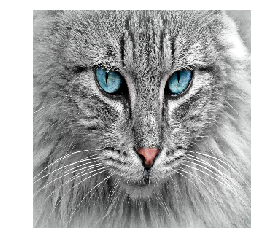

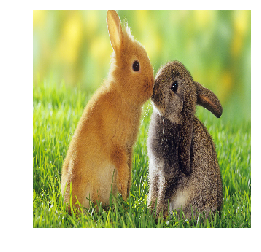

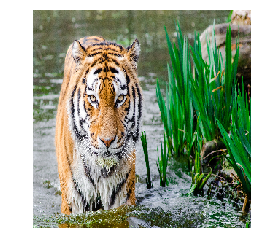

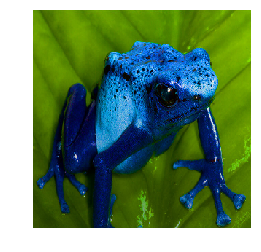

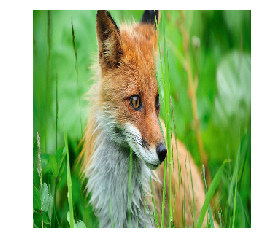

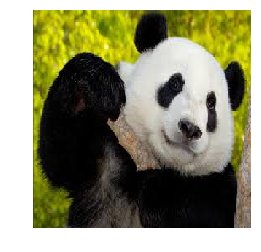

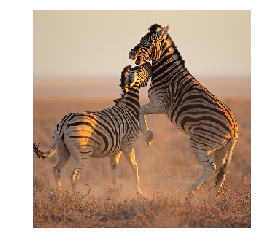

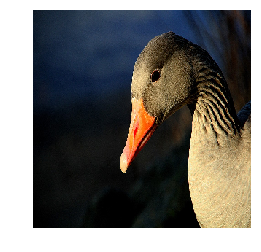

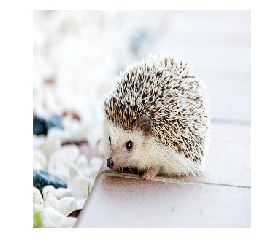

In [12]:
import os
from PIL import Image

animal_images_path = "./data/animal_images/"
animal_images = []
for path in os.listdir(animal_images_path):
    if os.path.isfile(animal_images_path + path):
        resized_image = Image.open(animal_images_path + path).resize((299, 299))
        show_image(resized_image)
        animal_images.append(2 * np.array(resized_image) / 256 - 1)
        #animal_images.append(np.array(resized_image))
animal_images = np.array(animal_images)

In [14]:
animal_images[0]

array([[[-0.5546875, -0.5234375, -0.53125  ],
        [-0.5234375, -0.4921875, -0.5      ],
        [-0.6171875, -0.5859375, -0.578125 ],
        ..., 
        [-0.53125  , -0.5      , -0.5078125],
        [-0.4609375, -0.453125 , -0.421875 ],
        [-0.4921875, -0.4765625, -0.484375 ]],

       [[-0.515625 , -0.484375 , -0.4921875],
        [-0.5546875, -0.5234375, -0.53125  ],
        [-0.5859375, -0.5546875, -0.546875 ],
        ..., 
        [-0.5078125, -0.4765625, -0.484375 ],
        [-0.484375 , -0.453125 , -0.4453125],
        [-0.46875  , -0.4375   , -0.4453125]],

       [[-0.4765625, -0.4453125, -0.4375   ],
        [-0.5859375, -0.5546875, -0.546875 ],
        [-0.546875 , -0.515625 , -0.5234375],
        ..., 
        [-0.5      , -0.46875  , -0.4765625],
        [-0.4765625, -0.4453125, -0.453125 ],
        [-0.4921875, -0.4609375, -0.453125 ]],

       ..., 
       [[-0.5078125, -0.4765625, -0.46875  ],
        [-0.484375 , -0.453125 , -0.4609375],
        [-0.5      

In [3]:
# Code copied from https://github.com/tensorflow/models/tutorials/image/imagenet/classify_image.py

# Copyright 2015 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

import sys
import urllib
import tarfile

DATA_URL = 'http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz'
CHECKPOINT_DIRECTORY = "./inception_v3"

def get_inception_v3_checkpoint_filepath():
  filename = DATA_URL.split('/')[-1]
  return os.path.join(CHECKPOINT_DIRECTORY, filename)
    
def maybe_download_and_extract():
  """Download and extract model tar file."""
  if not os.path.exists(CHECKPOINT_DIRECTORY):
    os.makedirs(CHECKPOINT_DIRECTORY)
  filepath = get_inception_v3_checkpoint_filepath()
  print(filepath)
  if not os.path.exists(filepath):
    def _progress(count, block_size, total_size):
      sys.stdout.write('\r>> Downloading %s %.1f%%' % (
          filename, float(count * block_size) / float(total_size) * 100.0))
      sys.stdout.flush()
    filepath, _ = urllib.request.urlretrieve(DATA_URL, filepath, _progress)
    print()
    statinfo = os.stat(filepath)
    print('Successfully downloaded', filename, statinfo.st_size, 'bytes.')
  tarfile.open(filepath, 'r:gz').extractall(CHECKPOINT_DIRECTORY)

maybe_download_and_extract()

./inception_v3/inception_v3_2016_08_28.tar.gz


In [4]:
from tensorflow.contrib.slim.python.slim.nets import inception_v3
import tensorflow.contrib.slim as slim

# Create Inception v3 Model.
X = tf.placeholder(tf.float32, shape=[None, 299, 299, 3])
with slim.arg_scope(inception_v3.inception_v3_arg_scope()):
    logits, end_points = inception_v3.inception_v3(
        X, num_classes=1001, is_training=False)
predictions = end_points["Predictions"]
saver = tf.train.Saver()

In [5]:
# Copied from https://github.com/ageron/handson-ml/blob/master/13_convolutional_neural_networks.ipynb

import re

class_names_url = "https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/inception/imagenet_class_names.txt"
CLASS_NAME_REGEX = re.compile(r"^n\d+\s+(.*)\s*$", re.M | re.U)

def load_class_names():
    filepath = os.path.join(CHECKPOINT_DIRECTORY, "imagenet_class_names.txt")
    filepath, _ = urllib.request.urlretrieve(class_names_url, filepath)
    with open(filepath, "rb") as f:
        content = f.read().decode("utf-8")
        return CLASS_NAME_REGEX.findall(content)
    
class_names = ["background"] + load_class_names()
print(class_names[:5])

['background', 'tench, Tinca tinca', 'goldfish, Carassius auratus', 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 'tiger shark, Galeocerdo cuvieri']


INFO:tensorflow:Restoring parameters from ./inception_v3/inception_v3.ckpt


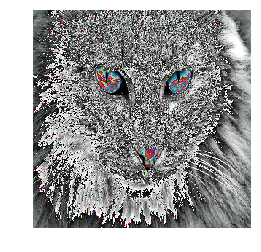

great grey owl, great gray owl, Strix nebulosa: 7.06%
lynx, catamount: 6.82%
tabby, tabby cat: 2.83%
peacock: 1.73%
fountain: 1.24%


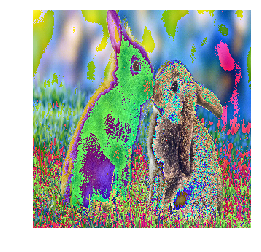

coral reef: 46.30%
hip, rose hip, rosehip: 7.82%
chain: 4.62%
padlock: 2.89%
rock beauty, Holocanthus tricolor: 2.37%


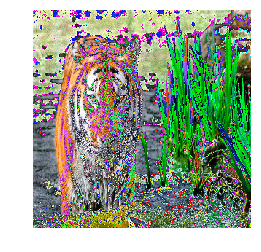

jigsaw puzzle: 32.89%
Indian elephant, Elephas maximus: 5.09%
prayer rug, prayer mat: 3.88%
quilt, comforter, comfort, puff: 1.99%
tiger, Panthera tigris: 1.85%


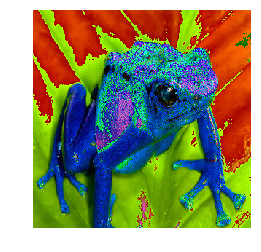

common iguana, iguana, Iguana iguana: 21.24%
green lizard, Lacerta viridis: 20.12%
tree frog, tree-frog: 7.91%
tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui: 5.85%
African chameleon, Chamaeleo chamaeleon: 2.20%


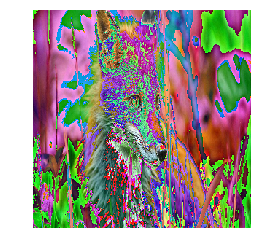

coyote, prairie wolf, brush wolf, Canis latrans: 23.16%
grey fox, gray fox, Urocyon cinereoargenteus: 11.71%
timber wolf, grey wolf, gray wolf, Canis lupus: 6.50%
red wolf, maned wolf, Canis rufus, Canis niger: 5.66%
kit fox, Vulpes macrotis: 4.06%


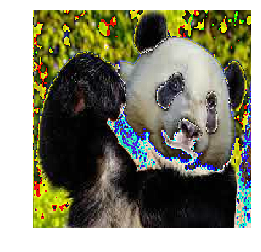

giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca: 20.58%
miniature schnauzer: 7.53%
Yorkshire terrier: 7.21%
silky terrier, Sydney silky: 7.16%
Dandie Dinmont, Dandie Dinmont terrier: 2.57%


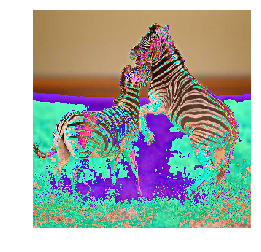

zebra: 81.48%
tiger, Panthera tigris: 1.91%
tiger cat: 0.49%
wallet, billfold, notecase, pocketbook: 0.45%
jigsaw puzzle: 0.41%


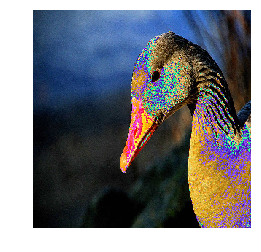

European gallinule, Porphyrio porphyrio: 34.90%
goose: 20.80%
drake: 10.14%
black swan, Cygnus atratus: 4.02%
peacock: 2.31%


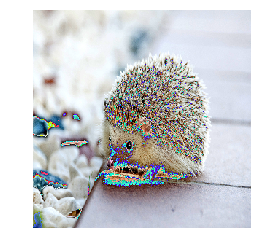

porcupine, hedgehog: 93.48%
echidna, spiny anteater, anteater: 0.33%
beaver: 0.09%
meerkat, mierkat: 0.09%
ostrich, Struthio camelus: 0.08%


In [15]:
with tf.Session() as sess:
    saver.restore(sess, os.path.join(CHECKPOINT_DIRECTORY, "inception_v3.ckpt"))
    predictions_val = sess.run([predictions], feed_dict={X: animal_images})

    predictions_val = np.squeeze(predictions_val)

    num_top_predictions = 5
    for i in range(len(predictions_val)):
        p = predictions_val[i]
        show_image(animal_images[i])
        top_5 = np.argpartition(p, -num_top_predictions)[-num_top_predictions:]
        top_5 = reversed(top_5[np.argsort(p[top_5])])
        for i in top_5:
            print("{0}: {1:.2f}%".format(class_names[i], 100 * p[i]))

The pre-trained Inception v3 model got 8 out of 9 correct (in top-5 ranking), or 88.9% correct and 3 out of 9 correct (in top-1 ranking), or 33.3% correct.

In [5]:
import os
#os.system("shutdown")

0